In [1]:
import tensorflow as tf
import cv2 as cv
from google.colab.patches import cv2_imshow
import numpy as np
from matplotlib import pyplot as plt
from keras import models
from keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from keras.callbacks import  EarlyStopping
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from keras import  backend as K
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
# Load pre-trained VGG-16 model
model = tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape= None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

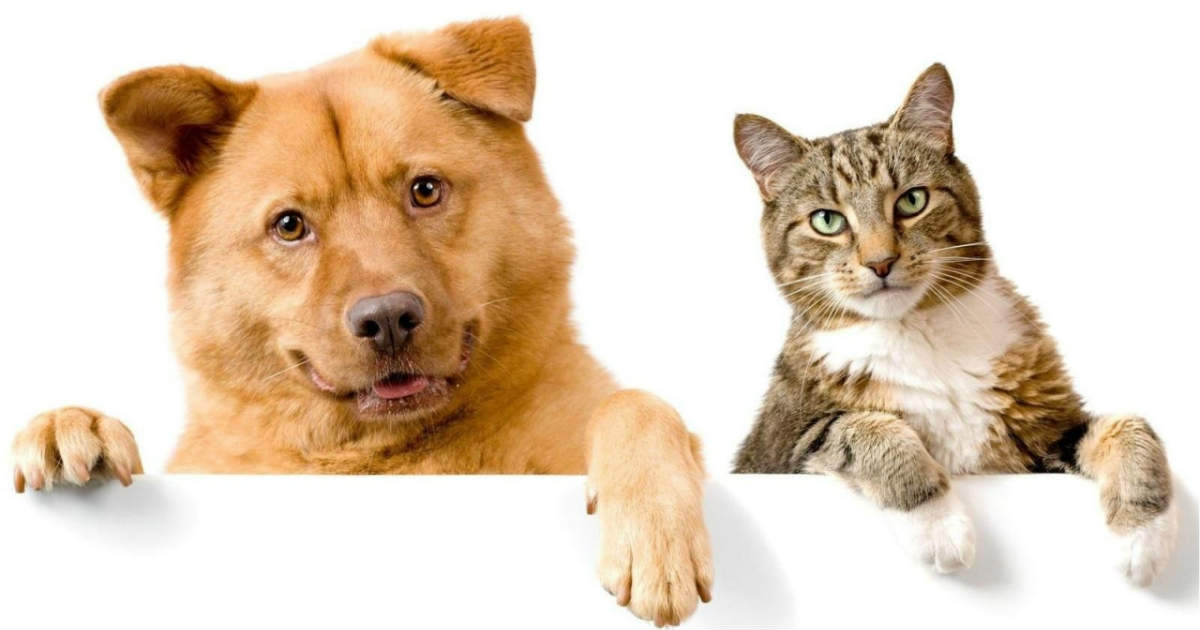

[[('n02106662', 'German_shepherd', 0.13195911), ('n02129604', 'tiger', 0.12158568), ('n02096051', 'Airedale', 0.09637665)]]


In [3]:
# Read the image and resize to the input's size of the moddel
img = cv.imread("drive/MyDrive/CV_data/assignment4/gc1.jpg")
x = cv.resize(img, (224,224))
x = np.expand_dims( x, axis = 0)
prediction = model.predict(x)
cv2_imshow(img)
print(decode_predictions(prediction, top = 3))
last_layer = model.get_layer('block5_conv3')


In [4]:
# Calulate Gradient of specific class
def calculate_grads(model, last_layer, rank):
  heatmap_model = tf.keras.models.Model(
    [model.inputs], [last_layer.output, model.output]
  )
  with tf.GradientTape() as gtape:
    conv_output, predictions = heatmap_model(x)
    predictions = tf.sort(predictions, axis = -1)
    #print(decode_predictions(predictions, top = 3))
    loss = predictions[:,-rank]
    print(loss)
  grads = gtape.gradient(loss,conv_output)
  return grads,conv_output

In [5]:
grads, conv_output = calculate_grads(model, last_layer,1)

tf.Tensor([0.13195911], shape=(1,), dtype=float32)


In [6]:
# Calculate average the gradient value
a = []
for i in range(grads.shape[3]):
  result = 1/(14*14)*np.sum(grads[:,:,:,i])
  a.append(result)

In [7]:
# Relu function
def relu(x):
    return max(0.0, x)

In [8]:
# Calculate weightd combination of activation maps
def compute_weighted_activation_maps(a, conv_output):
  L = np.zeros((14,14))
  for i in range(512):
    L = L + a[i]*conv_output.numpy()[0,:,:,i]
  # Apply RELU function
  for i in range(L.shape[0]):
    for j in range(L.shape[1]):
      L[i][j] = relu(L[i][j])
  L = tf.squeeze(L)
  L = tf.maximum(L, 0) / tf.math.reduce_max(L)
  return L.numpy()

In [9]:
L = compute_weighted_activation_maps(a, conv_output)

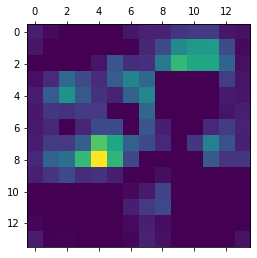

In [10]:
plt.matshow(L)

In [11]:
# Apply heat map to input image and display
def display_gradcam(img, heatmap, alpha=0.8):
    # Load the original image
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv.resize(heatmap, (img.shape[1],img.shape[0]), interpolation = cv.INTER_LINEAR)
    plt.matshow(heatmap)
    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap*alpha+ img
    #superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Display Grad CAM
    cv2_imshow(superimposed_img)



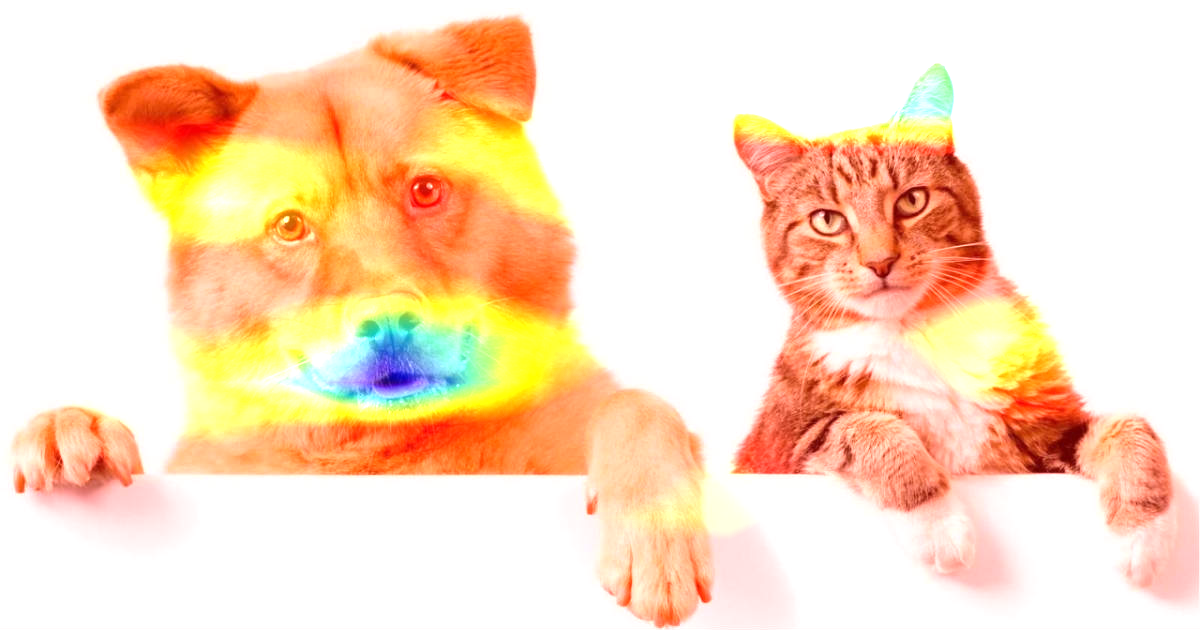

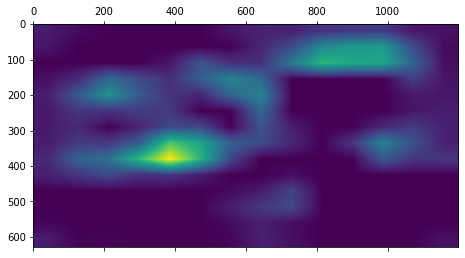

In [12]:
display_gradcam(img, L)